<a href="https://colab.research.google.com/github/mistryvivek/YRKCS-PRBX/blob/main/PADL_Week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PADL Practical Week 10: Deep generative models

There's a lot in this week's practical. You don't necessarily need to do it all. Everyone should try exercise 2 as it is essential for the assessment. Masters students should also try exercise 4. Exercise 1 is useful for helping your understanding and the result is somewhat intriguing. Exercise 3 is fun as you get to create photorealistic images from prompts.

##1. Adversarial perturbations

You will start by creating an "adversarial perturbation" of an image in order to break a classifier. This means you will find a small offset that can be added to an image to change the class assigned to it by a classifier. We will do this using a pretrained LeNet for MNIST digit classification. You will need to look at the third video lecture for this week (or at least the slides). First, let's set up the network and load the pretrained weights. The code below will download the `LeNet_weights.pkl` file and then load it into the model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!wget https://www-users.york.ac.uk/~waps101/PADL/LeNet_weights.pkl

--2024-11-07 09:33:02--  https://www-users.york.ac.uk/~waps101/PADL/LeNet_weights.pkl
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250572 (245K)
Saving to: ‘LeNet_weights.pkl’

LeNet_weights.pkl   100%[===================>] 244.70K   262KB/s    in 0.9s    

2024-11-07 09:33:04 (262 KB/s) - ‘LeNet_weights.pkl’ saved [250572/250572]



In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=5*5*16,out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120,out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84,out_features=10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

model = LeNet()
model.load_state_dict(torch.load('LeNet_weights.pkl',map_location=torch.device(device)))

<ipython-input-3-d4dd1136e765>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('LeNet_weights.pkl',map_location=torch.device(device)))


<All keys matched successfully>

You now have a network that is good at classifying the MNIST digit dataset. Let's take the first test image, run it through the network and check its classification and how confident it is.

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



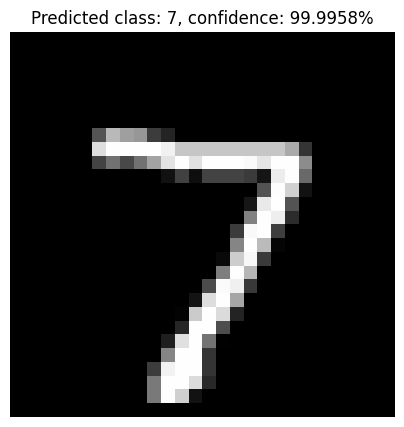

In [4]:
test_data = datasets.MNIST(root = 'data', train = False, transform = transforms.ToTensor(), download=True)
# Extract the first test image (correct class=7)
image,label = test_data[0]
# Make a batch of just this image
images = image.unsqueeze(0)
# Run image through pretrained network
output = model(images)
# Find highest probability class
pred_y = torch.argmax(output, 1)
# Convert logits to probabilities
probs = nn.functional.softmax(output,dim=1)

figure = plt.figure(figsize=(5,5))
plt.title("Predicted class: {}, confidence: {:.4f}%".format(pred_y[0],probs[0,pred_y[0]]*100))
plt.axis("off")
plt.imshow(image[0,:], cmap="gray")
plt.show()

It's very confident that this is a seven!

**To do**: You now need to solve an optimisation problem to find the perturbation $\mathbf{r}$ to the input image $\mathbf{x}$ such that $\mathbf{x}+\mathbf{r}$ is classified as a zero instead of a seven. The loss that your optimisation will seek to minimise is a sum of two losses:

1. Cross entropy loss with the incorrect label of `[0]`.
2. A loss to keep the magnitude of the perturbation small (i.e. to change the image as little as possible). Using the sum of the squared value of all elements of $\mathbf{r}$ works ok for this.

The loss you will optimise should be the sum of these two losses with the second weighted by a parameter $c$. This parameter trades off how much it modifies the image against how much it can change the classification result. Start off with $c=1.0$.

The only thing you are optimising is $\mathbf{r}$. Look back at the week 1 practical if you can't remember how to use PyTorch to directly optimise a variable. Initialise $\mathbf{r}$ as all zeros.

During the optimisation, print out the value of the two losses. The magnitude of the perturbation will start off as zero so must increase in order to decrease the classification loss. You might need to play with the value of $c$ to get a desirable result. Also print out the current classification result so you can see when it switches its mind to class zero.

Once you think you have a good result, visualise the perturbed image and also the perturbation on its own. You can also try different incorrect classes. Can you get it to change its mind with a less obvious perturbation for other classes?

##2. GANs

We're going to train a GAN using the same Fashion MNIST dataset as last week. We'll use the built-in dataloader this time. A few things to note:
1. for a GAN, we only need a training set (a validation set doesn't really make any sense in the context of a GAN)
2. the dataset is originally 28 x 28 images, I've padded this to 32 x 32 using the `transforms.CenterCrop` transform (it made it easier to reuse the DCGAN architecture later).
3. the GAN trains better if you normalise your image data to be scaled between -1 and 1 (rather than 0 and 1). This is done with `transforms.Normalize`.

Let's start by importing everything we need, setting up some parameters and setting up the data loader.

Note: training the GAN is slow. You might want to choose Edit -> Notebook settings -> Hardware accelerator -> GPU now.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define some parameters
batch_size = 100
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 5 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

# Set up the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(32),transforms.Normalize(0.5,0.5)])
train_data = datasets.FashionMNIST(root = 'data', train = True, transform = transform, download = True)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.87MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.25MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



As last week, let's grab a batch of images and visualise the first 25 images. I've negated the image brightness to put the images back to how they originally looked - this is a nicer way to visualise them. You can use this code as a starting point for the visualisation tasks below.

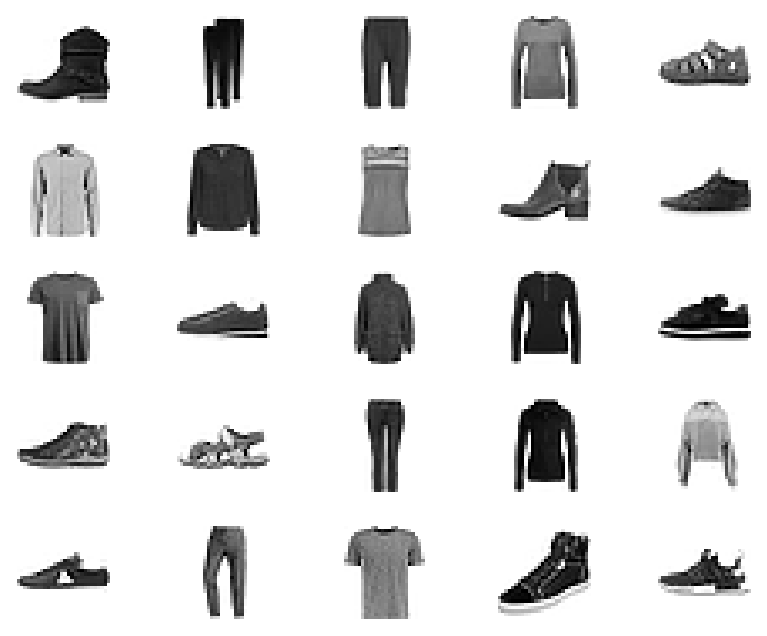

In [6]:
images, labels = next(iter(dataloader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze(), cmap="gray")
plt.show()

###Generator architecture

I have roughly followed the DCGAN architecture. The Generator takes as input a latent (`z`) vector which has `nz` dimensions. Via an expansive network with transposed convolutions, it converts this into a 32 x 32 image. To map the final output to the range -1..1 we use the Tanh activation function.

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size: B x (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size: B x (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size: B x (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
            # Size: B x 1 x 32 x 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

###Discriminator architecture

The discriminator is a conventional binary classification CNN: it takes an image as input and outputs the probability that the image is real. I've again followed the DCGAN architecture which uses something you haven't seen before: LeakyReLU. This is a variant on ReLU where negative values are allowed to "leak" through, albeit scaled down. Everything else you should have seen before.

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. 1 x 32 x 32
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

###GAN training

We're now ready to train our GAN. The training loop for a GAN is pretty complicated so look through the following code carefully and read the comments. You may want to refer to the fifth video lecture for this week to help understand it. You can try running it for a while to train your own GAN but it's slow and below I provide some pretrained weights. Note: even though the data loader is returning labels, we're not using them here. A GAN doesn't need labels.

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images,labels) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(z)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


Starting Training Loop...
[1/5][0/600]	Loss_D: 1.4427	Loss_G: 1.2019	D(x): 0.5215	D(G(z)): 0.5359 / 0.3083
[1/5][50/600]	Loss_D: 0.0447	Loss_G: 5.1955	D(x): 0.9845	D(G(z)): 0.0284 / 0.0064
[1/5][100/600]	Loss_D: 0.6630	Loss_G: 4.0866	D(x): 0.8920	D(G(z)): 0.3959 / 0.0211
[1/5][150/600]	Loss_D: 0.4047	Loss_G: 2.5274	D(x): 0.7811	D(G(z)): 0.1120 / 0.0967
[1/5][200/600]	Loss_D: 0.4399	Loss_G: 2.2320	D(x): 0.7438	D(G(z)): 0.0948 / 0.1332
[1/5][250/600]	Loss_D: 0.8676	Loss_G: 1.7910	D(x): 0.5095	D(G(z)): 0.0365 / 0.2069
[1/5][300/600]	Loss_D: 0.5261	Loss_G: 2.1440	D(x): 0.6922	D(G(z)): 0.0982 / 0.1471
[1/5][350/600]	Loss_D: 0.3880	Loss_G: 2.3078	D(x): 0.8371	D(G(z)): 0.1724 / 0.1238
[1/5][400/600]	Loss_D: 0.3932	Loss_G: 2.6144	D(x): 0.8058	D(G(z)): 0.1368 / 0.0923
[1/5][450/600]	Loss_D: 0.5489	Loss_G: 2.3248	D(x): 0.8218	D(G(z)): 0.2532 / 0.1227
[1/5][500/600]	Loss_D: 0.6029	Loss_G: 3.1015	D(x): 0.8777	D(G(z)): 0.3494 / 0.0626
[1/5][550/600]	Loss_D: 0.5329	Loss_G: 1.2714	D(x): 0.6948	D(G(z)

###Visualise GAN output

**To do**:

Generate some random latent codes, pass them through the generator to get images and then visualise them like we visualised the random training images above.

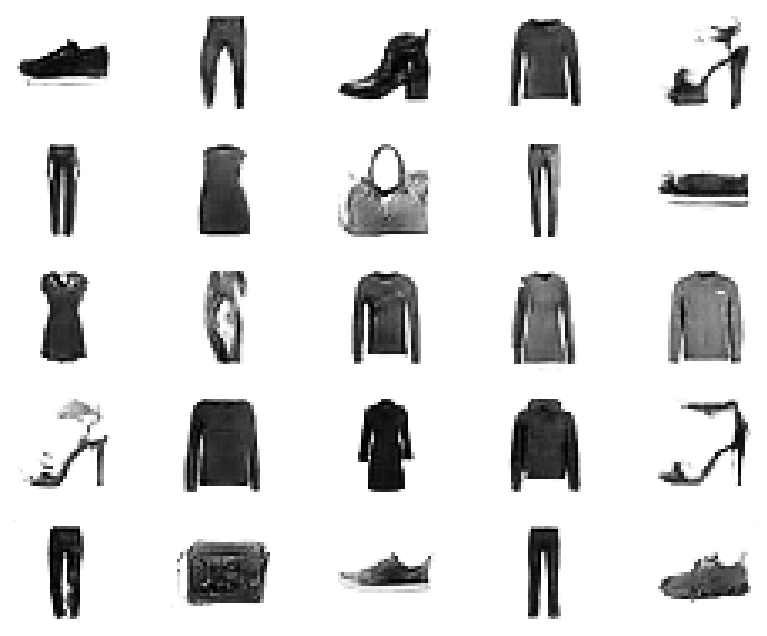

In [12]:
# Random sample over normal distro.
# Tensor from random normal distribution.
# (number of inputs, latent space, spatical dimensions)
z = torch.randn(25,nz,1,1,device=device)
# Put through generator.
images = netG(z)

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].cpu().detach().squeeze(), cmap="gray")
plt.show()

###Loading pretrained weights

The above training loop is starting to take quite a lot of time, even using a GPU. 5 epochs is not enough for good results. So I've pretrained a network for you that I trained for 100 epochs. Download my pretrained weights and load them into your network, then try running your visualisation code again. Are the results noticably better?

In [11]:
!wget https://www-users.york.ac.uk/~waps101/PADL/netG.pkl
netG.load_state_dict(torch.load('netG.pkl',map_location=torch.device(device)))
netG.eval()

--2024-11-07 09:56:15--  https://www-users.york.ac.uk/~waps101/PADL/netG.pkl
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4276652 (4.1M)
Saving to: ‘netG.pkl’

netG.pkl            100%[===================>]   4.08M   764KB/s    in 5.7s    

2024-11-07 09:56:21 (736 KB/s) - ‘netG.pkl’ saved [4276652/4276652]



<ipython-input-11-4149632288ed>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('netG.pkl',map_location=torch.device(device)))


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

##Latent space interpolation

One of the interesting things about GANs is that the latent space of the generator provides a set of parameters that can be manipulated to change the appearance of the image in a smooth way. Walking around in the latent space results in an image that gradually varies hopefully remaining plausible all the time. The easiest way try this out is by linearly interpolating between two samples.

**To do**:

Write some code that starts by generating two random latent codes, `z1` and `z2`. Now create a batch of 9 latent codes that linearly interpolates between them so that the first element in the batch is equal to `z1`, the ninth is equal to `z2` and the fifth (i.e. the middle element) is equal to `0.5*z1 + 0.5*z2`. Pass the batch of latent codes through your generator (remember to put the generator in eval mode first with `netG.eval()` so that the batchnorm layers use the learnt means/stds). Now display the resulting images (adapt the code we've used previously for visualing images from a batch). You should see a gradual transition from one image to the other and the intermediates should look reasonable (although it's hard to interpolate from a handbag to a pair of trousers!)

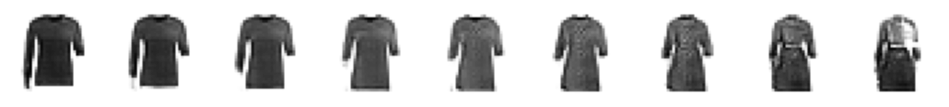

In [13]:
# Take 9 samples.
nsamples = 9
# Take a random set of values.
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
# A tensors of zeroes in the same format as everything else.
z = torch.zeros(nsamples,nz,1,1,device=device)
# For all 9 samples.
for i in range(nsamples):
  w1 = i/(nsamples-1)
  # Ensures that the weight is always 1
  w2 = 1-w1
  z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()

##3. Play with a pretrained diffusion model

First we need to install some dependencies and import. This takes a few minutes to run so take a break while it's running!

In [ ]:
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = pipe.to(device)

Now it's time to play! This diffusion implementation comes with a nice end to end text-to-image pipeline. You simply need to provide a text prompt and it will generate an image. You will get a different result every time as the starting random noise will be different. Experiment with different prompts.

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt).images[0]  # image here is in PIL format

# directly display the generated image
image

`pipe` can take various other option parameters. Try playing with `num_inference_steps` which controls how many diffusion steps are used (fewer is faster but lower quality), `height` and `width` which control the size of the output and `guidance_scale` which controls how much weight it gives to your text prompt.

Let's now dig a little deeper and see a denoising loop in action. First, some setup:

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

Prepare our inputs:

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Random initial latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)

scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

Now we are ready to run the denoising loop:

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

Visualise the result:

In [ ]:
from PIL import Image

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

**To do**: At any point in the loop, you could convert the noisy latents to an image using the VAE decoder. Try this out. You should be able to visualise the result gradually transitioning from noise to the final image.

##4. Create a conditional GAN (highly recommended for MEng students)

I would now like you to extend the GAN created above to make it into a conditional GAN. This means that the generator takes both a z latent vector and also a class label and generates an image of the appropriate class. The discriminator takes an image plus the class label and returns the probability that this is a real image of that class. There are many ways you could engineer the generator and discriminator architectures to take labels as input but here is my suggestion:
- Use a `torch.nn.Embedding` layer to turn the class label into a feature vector. A dimensionality of 50 for this feature vector works well.
- In the generator you can then just concatenate this embedding with the `z` vector and feed it into the same generator architecture as above.
- In the discriminator, use another linear layer to transform the embedding up to size 32 x 32. You can then just concatenate this as an additional channel to the image that you pass into the same architecture as above (just with two input channels rather than 1).
- The training loop is very similar to above but now you pass the real labels along with the real images to the discriminator. When you create a random batch of fake images, you need to generate some random labels. These should also be passed to the discriminator.

Once you get it to train, try visualing random output for each class. For example, fix the label to zero then generate 8 images, then repeat for labels 1-9. You should see the right class but random variation within that class when you vary z.